## Pronóstico de series de tiempo de precipitación con autoencoder (CR2MET)

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, Model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

from numpy.lib.stride_tricks import sliding_window_view
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import mixed_precision
import math

gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("GPUs:", gpus)

mixed_precision.set_global_policy("mixed_float16")
print("Policy:", mixed_precision.global_policy())

2025-10-16 00:22:42.591697: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 00:22:42.845803: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-16 00:22:42.845826: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-16 00:22:42.847153: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-16 00:22:42.963990: I tensorflow/core/platform/cpu_feature_g

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Laptop GPU, compute capability 8.9
Policy: <Policy "mixed_float16">


2025-10-16 00:22:46.449753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-16 00:22:46.467396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-16 00:22:46.467433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-16 00:22:46.467953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
folder = "../data/CR2MET_pr_v2.5/"
files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".nc")]
ds = xr.open_mfdataset(files, combine='by_coords')
ds['pr'] = ds['pr'].fillna(0)
ds

/tmp/ipykernel_724/1078490275.py:3: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xr.open_mfdataset(files, combine='by_coords')


<xarray.Dataset> Size: 54GB
Dimensions:  (time: 15341, lat: 800, lon: 220)
Coordinates:
  * lon      (lon) float64 2kB -76.97 -76.92 -76.88 ... -66.12 -66.08 -66.03
  * lat      (lat) float64 6kB -56.98 -56.93 -56.88 ... -17.12 -17.07 -17.02
  * time     (time) datetime64[ns] 123kB 1980-01-01 1980-01-02 ... 2021-12-31
Data variables:
    pr       (time, lat, lon) float64 22GB dask.array<chunksize=(31, 800, 220), meta=np.ndarray>
    pr_sd    (time, lat, lon) float64 22GB dask.array<chunksize=(31, 800, 220), meta=np.ndarray>
    cl_mask  (time, lat, lon) float32 11GB dask.array<chunksize=(31, 800, 220), meta=np.ndarray>
Attributes: (12/28)
    creation_date:        29-Aug-2022 18:46:14
    authors:              Boisier et al.
    obs_file:             MERGE5_QC_UCC_pr_day_1979_2021.csv
    topo_res:             005 025 05
    ls_vars_all:          pr logpr prc prmax pr2d iqu iqv tcw cape
    ls_vars_o15:          iqu iqv tcw cape
    ...                   ...
    ens_qtl_value:        0.5
    log_pr_thre:          10
    ens_force_dry:        0
    AV_obs_file:          MERGE5_QC_FI_full_pr_mon_1960_2021_ny_min_20.csv
    AV_n_modes_pca:       50
    AV_n_modes_cca:       25

In [3]:

time_test = ["2019-01-01",None]

ds = ds.sel(time=slice(time_test[0], time_test[1])) # Filtra desde 2000 a 2022
# zona Maule - Ñuble
ds = ds.where((ds.lat <= -34) & (ds.lat >= -38), drop=True)
ds = ds.where((ds.lon <= -70) & (ds.lon >= -73), drop=True)
ds['pr'] = ds['pr'].where(ds['pr'] >= 0, 0) # Hace toda pr>=0

# rename Vars
ds = ds.rename({'lat': 'latitude', 'lon': 'longitude'})
ds

<xarray.Dataset> Size: 105MB
Dimensions:    (time: 1096, latitude: 80, longitude: 60)
Coordinates:
  * longitude  (longitude) float64 480B -72.97 -72.92 -72.88 ... -70.08 -70.03
  * latitude   (latitude) float64 640B -37.98 -37.92 -37.88 ... -34.08 -34.02
  * time       (time) datetime64[ns] 9kB 2019-01-01 2019-01-02 ... 2021-12-31
Data variables:
    pr         (time, latitude, longitude) float64 42MB dask.array<chunksize=(31, 80, 60), meta=np.ndarray>
    pr_sd      (time, latitude, longitude) float64 42MB dask.array<chunksize=(31, 80, 60), meta=np.ndarray>
    cl_mask    (time, latitude, longitude) float32 21MB dask.array<chunksize=(31, 80, 60), meta=np.ndarray>
Attributes: (12/28)
    creation_date:        29-Aug-2022 18:46:14
    authors:              Boisier et al.
    obs_file:             MERGE5_QC_UCC_pr_day_1979_2021.csv
    topo_res:             005 025 05
    ls_vars_all:          pr logpr prc prmax pr2d iqu iqv tcw cape
    ls_vars_o15:          iqu iqv tcw cape
    ...                   ...
    ens_qtl_value:        0.5
    log_pr_thre:          10
    ens_force_dry:        0
    AV_obs_file:          MERGE5_QC_FI_full_pr_mon_1960_2021_ny_min_20.csv
    AV_n_modes_pca:       50
    AV_n_modes_cca:       25

In [4]:
# =========================
# 3) Extrae tensor base (T, H, W, C)
# =========================
pr = ds["pr"]  # mm por paso temporal
# Asegura dtype
pr = pr.astype("float32")

# Manejo de NaNs: relleno + canal máscara (opcional)
use_mask_channel = False
if pr.isnull().any():
    use_mask_channel = True
    mask = xr.where(pr.notnull(), 1.0, 0.0).astype("float32")
    pr = pr.fillna(0.0)

# A (T,H,W)
X = pr.transpose("time", "latitude", "longitude").values  # -> (T,H,W)
T_total, H, W = X.shape

# Apila canales
channels = [X[..., None]]  # C=1
if use_mask_channel:
    M = mask.transpose("time", "latitude", "longitude").values.astype("float32")
    channels.append(M[..., None])  # C+=1
X_full = np.concatenate(channels, axis=-1).astype("float32")  # (T,H,W,C)
C = X_full.shape[-1]

print("Forma maestro:", X_full.shape)  # esperado: (8401, 41, 41, C)

Forma maestro: (1096, 80, 60, 1)


In [5]:
# =========================
# 4) Splits temporales (ajusta fechas a tu rango real)
# =========================
# Usa las fechas del dataset para que no falle si no tienes todo 2000–2022
t0 = np.datetime_as_string(ds.time.values[0], unit="D")
t1 = np.datetime_as_string(ds.time.values[-1], unit="D")
print("Rango temporal:", t0, "→", t1)

Rango temporal: 2019-01-01 → 2021-12-31


In [6]:
def to_array(dsi):
    arr = dsi["pr"].transpose("time", "latitude", "longitude").astype("float32")
    if use_mask_channel:
        m = xr.where(dsi["pr"].notnull(), 1.0, 0.0).transpose("time","latitude","longitude").astype("float32")
        arr = xr.concat([arr, m], dim="channel")  # (time, lat, lon, channel) pero falta expand
        arr = arr.transpose("time","latitude","longitude","channel")
        return arr.values
    else:
        return arr.values[..., None]

Xte = to_array(ds)

print("Test:", Xte.shape)

Test: (1096, 80, 60, 1)


In [8]:
def match_shape_3d(x, target):
    sx = tf.shape(x)
    st = tf.shape(target)

    # Diferencias por eje (T, H, W, C)
    dT = st[1] - sx[1]
    dH = st[2] - sx[2]
    dW = st[3] - sx[3]

    # ---- PAD si falta (negativo = falta -> pad positivo)
    pad_T = tf.maximum(dT, 0)
    pad_H = tf.maximum(dH, 0)
    pad_W = tf.maximum(dW, 0)

    # repartir pad a izquierda/derecha de forma casi simétrica
    def split_pad(d):
        left = d // 2
        right = d - left
        return left, right

    pT0, pT1 = split_pad(pad_T)
    pH0, pH1 = split_pad(pad_H)
    pW0, pW1 = split_pad(pad_W)

    x = tf.pad(x, [[0,0],[pT0,pT1],[pH0,pH1],[pW0,pW1],[0,0]], mode="CONSTANT")

    # ---- CROP si sobra (positivo = sobra -> recorte)
    # Recalcular shape tras posible pad
    sx2 = tf.shape(x)
    cT = tf.maximum(sx2[1] - st[1], 0)
    cH = tf.maximum(sx2[2] - st[2], 0)
    cW = tf.maximum(sx2[3] - st[3], 0)

    # recorte centrado
    sT = cT // 2
    sH = cH // 2
    sW = cW // 2

    x = x[:, sT:sT+st[1], sH:sH+st[2], sW:sW+st[3], :]
    return x

In [9]:
version_ae = "v1.5"

data_norm = np.load(f"../models/normalizacion_pr_{version_ae}.npz")
mu = data_norm["mu"]
sd = data_norm["sd"]
T_window = data_norm["T_window"].item()     # si es un escalar
stride = data_norm["stride"].item()
use_mask_channel = data_norm["use_mask_channel"].item()


ae = load_model(f"../models/ae_3d_CR2MET_pr_v2.5_pr_{version_ae}.keras", safe_mode=False)

In [10]:
T_window = 32   # longitud de ventana
stride   = 1    # salto entre ventanas
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE


def normalize(x, mu, sd):
    return (x - mu.reshape(1,1,1,C)) / sd.reshape(1,1,1,C)

def make_start_indices(T_total, T, S):
    n = max((T_total - T) // S + 1, 0)
    return np.arange(n, dtype=np.int32) * S

def dataset_from_array(X, T=32, S=4, batch=2, shuffle=4096, prefetch=2, training=True):
    # X: (T_total, H, W, C) ya normalizado (float16 recomendado)
    X_tf = tf.convert_to_tensor(X)  # no copia grande si ya es contiguous
    starts = make_start_indices(X.shape[0], T, S)

    ds = tf.data.Dataset.from_tensor_slices(starts)
    if training:
        ds = ds.shuffle(min(len(starts), shuffle), reshuffle_each_iteration=True)

    @tf.function  # forma y grafo estables
    def _extract(i):
        w = X_tf[i:i+T]              # (T,H,W,C)
        return w, w                  # AE: input = target

    ds = ds.map(_extract, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch, drop_remainder=False).prefetch(prefetch)
    return ds

test_ds = dataset_from_array(normalize(Xte, mu, sd), T=T_window, S=stride, batch=batch_size, shuffle=0, prefetch=AUTOTUNE, training=False)  # stride mayor en val

In [11]:
# =========================
# 10) Eval & ejemplo de uso
# =========================
test_loss = ae.evaluate(test_ds)
print("Test loss:", test_loss)

2025-10-16 00:25:18.914739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


67/67 [==============================] - 4s 27ms/step - loss: 5.3075e-05 - rmse: 0.0073
Test loss: [5.3074956667842343e-05, 0.007285255938768387]


In [12]:
xs, ys = [], []

for x_batch, y_batch in test_ds:
    xs.append(x_batch)
    ys.append(ae.predict(x_batch, verbose=0))

X_test = tf.concat(xs, axis=0)
Y_test = tf.concat(ys, axis=0)

In [13]:
#recons = ae.predict(test_ds, batch_size=8)[:,0,:,:,:]

# Flatten por ventana para evaluar MSE/MAE promedio
mse = np.mean((Y_test - X_test)**2)
mae = np.mean(np.abs(Y_test - X_test))
smape = np.mean(np.abs(2 * (Y_test - X_test) / (Y_test + X_test + np.finfo(float).eps)))

print(f"Test:")
print(f"MSE total  : {mse:.6f}")
print(f"MAE total  : {mae:.6f}")
print(f"SMAPE total: {smape*100:.3f} %")

Test:
MSE total  : 0.000053
MAE total  : 0.002845
SMAPE total: 4.035 %


In [14]:
def compare_plots_error(recons, Xte_w, d_time):
    # --- Promedios temporales globales ---
    orig_mean = np.mean(Xte_w[..., 0], axis=(0, 1))
    recon_mean = np.mean(recons[..., 0], axis=(0, 1))
    diff_mean = orig_mean - recon_mean

    fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    im0 = ax[0].imshow(orig_mean, cmap='viridis')
    ax[0].set_title('Original promedio')
    plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(recon_mean, cmap='viridis')
    ax[1].set_title('Reconstruido promedio')
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    im2 = ax[2].imshow(diff_mean, cmap='RdBu', vmin=-np.max(abs(diff_mean)), vmax=np.max(abs(diff_mean)))
    ax[2].set_title('Diferencia (Original - Reconstruido)')
    plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

    # --- Errores espaciales promedio ---
    rmse_map = np.sqrt(np.mean((recons - Xte_w)**2, axis=(0, 1, 4)))   # (H, W)
    mae_map  = np.mean(np.abs(recons - Xte_w), axis=(0, 1, 4))         # (H, W)

    fig, ax = plt.subplots(1, 2, figsize=(11, 4))
    im0 = ax[0].imshow(rmse_map, cmap='inferno')
    ax[0].set_title('Error RMSE promedio por píxel')
    plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(mae_map, cmap='inferno')
    ax[1].set_title('Error MAE promedio por píxel')
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

    # --- Errores temporales promedio (por ventana) ---
    rmse_time = np.sqrt(np.mean((recons - Xte_w)**2, axis=(2, 3, 4)))  # (N, T)
    mae_time  = np.mean(np.abs(recons - Xte_w), axis=(2, 3, 4))        # (N, T)
    rmse_per_window = rmse_time.mean(axis=1)
    mae_per_window  = mae_time.mean(axis=1)

    # --- Energía media del campo original y reconstruido ---
    orig_energy  = np.mean(Xte_w[..., 0], axis=(2, 3)).mean(axis=1)
    recon_energy = np.mean(recons[..., 0], axis=(2, 3)).mean(axis=1)

    # === Evolución temporal (1): comparación original vs reconstruido ===
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(d_time, orig_energy, label='Original (energía media)', alpha=0.8)
    ax.plot(d_time, recon_energy, label='Reconstruido (energía media)', linestyle='--', alpha=0.9)
    ax.set_title('Evolución temporal: Original vs Reconstrucción')
    ax.set_xlabel('Ventana temporal (orden cronológico)')
    ax.set_ylabel('Valor medio del campo')
    ax.grid(alpha=0.3)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # === Evolución temporal (2): errores RMSE y MAE juntos ===
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(d_time, rmse_per_window, label='RMSE', color='tab:red', alpha=0.9)
    ax.plot(d_time, mae_per_window, label='MAE', color='tab:blue', alpha=0.9)
    ax.set_title('Evolución temporal de errores (RMSE y MAE)')
    ax.set_xlabel('Ventana temporal (orden cronológico)')
    ax.set_ylabel('Error')
    ax.grid(alpha=0.3)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # --- Distribución global de errores ---
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].hist(rmse_per_window, bins=40, color='tab:red', alpha=0.7)
    ax[0].set_title('Distribución de errores RMSE por ventana')
    ax[0].set_xlabel('RMSE'); ax[0].set_ylabel('Frecuencia')

    ax[1].hist(mae_per_window, bins=40, color='tab:blue', alpha=0.7)
    ax[1].set_title('Distribución de errores MAE por ventana')
    ax[1].set_xlabel('MAE'); ax[1].set_ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()


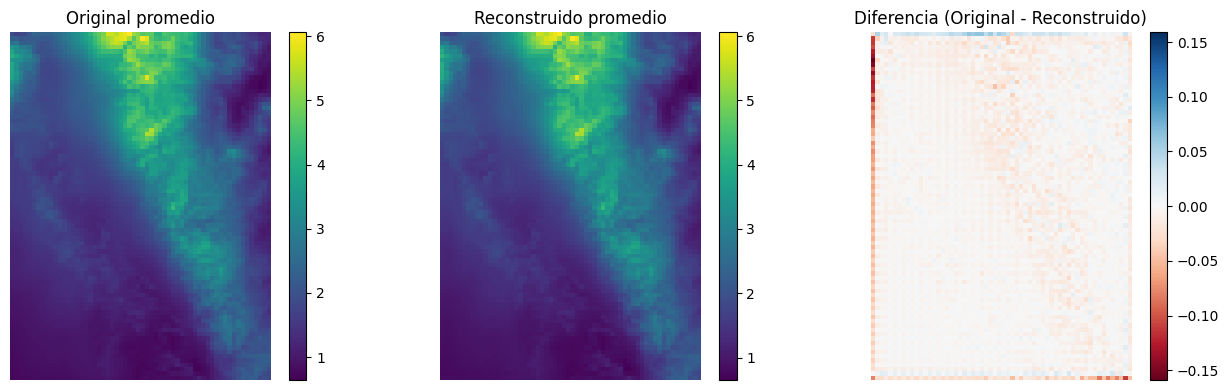

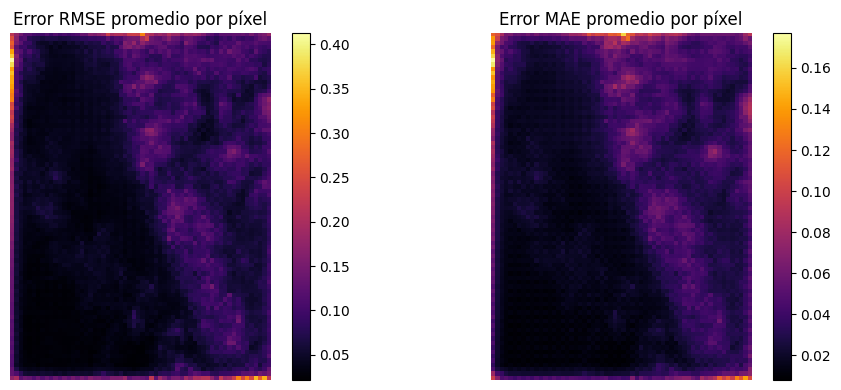

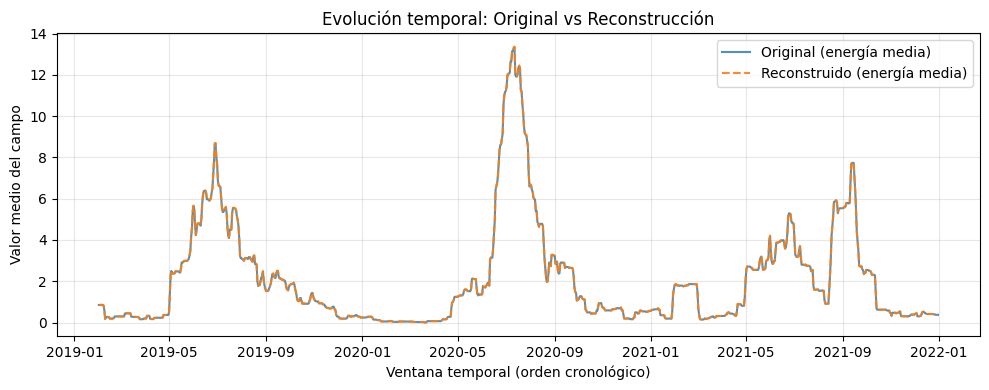

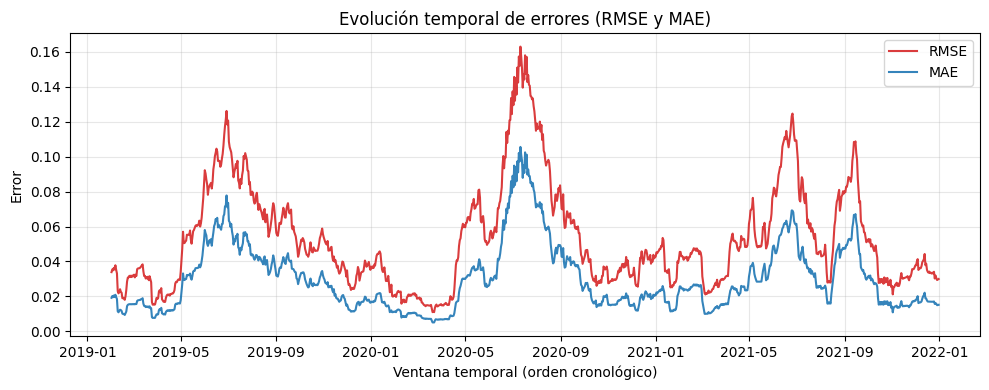

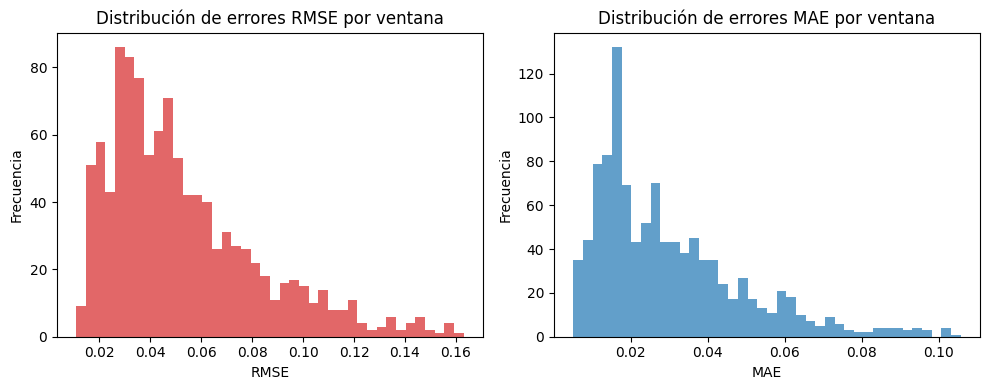

In [15]:
compare_plots_error(Y_test*sd + mu, X_test*sd + mu, ds['time'].values[-X_test.shape[0]:])

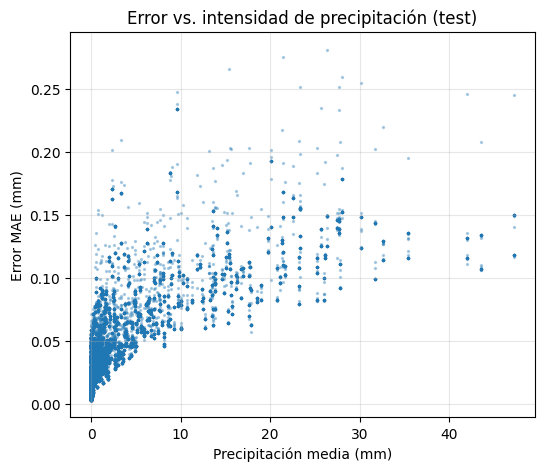

In [16]:
# Valor medio vs error (por frame)
orig_vals = np.mean(X_test[..., 0]*sd + mu, axis=(2, 3))   # (N, T)
err_vals  = np.mean(np.abs(Y_test*sd - X_test*sd), axis=(2, 3, 4)) # (N, T)

plt.figure(figsize=(6,5))
plt.scatter(orig_vals.flatten(), err_vals.flatten(), s=2, alpha=0.3)
plt.xlabel("Precipitación media (mm)")
plt.ylabel("Error MAE (mm)")
plt.title("Error vs. intensidad de precipitación (test)")
plt.grid(alpha=0.3)
plt.show()

<Figure size 2000x800 with 0 Axes>

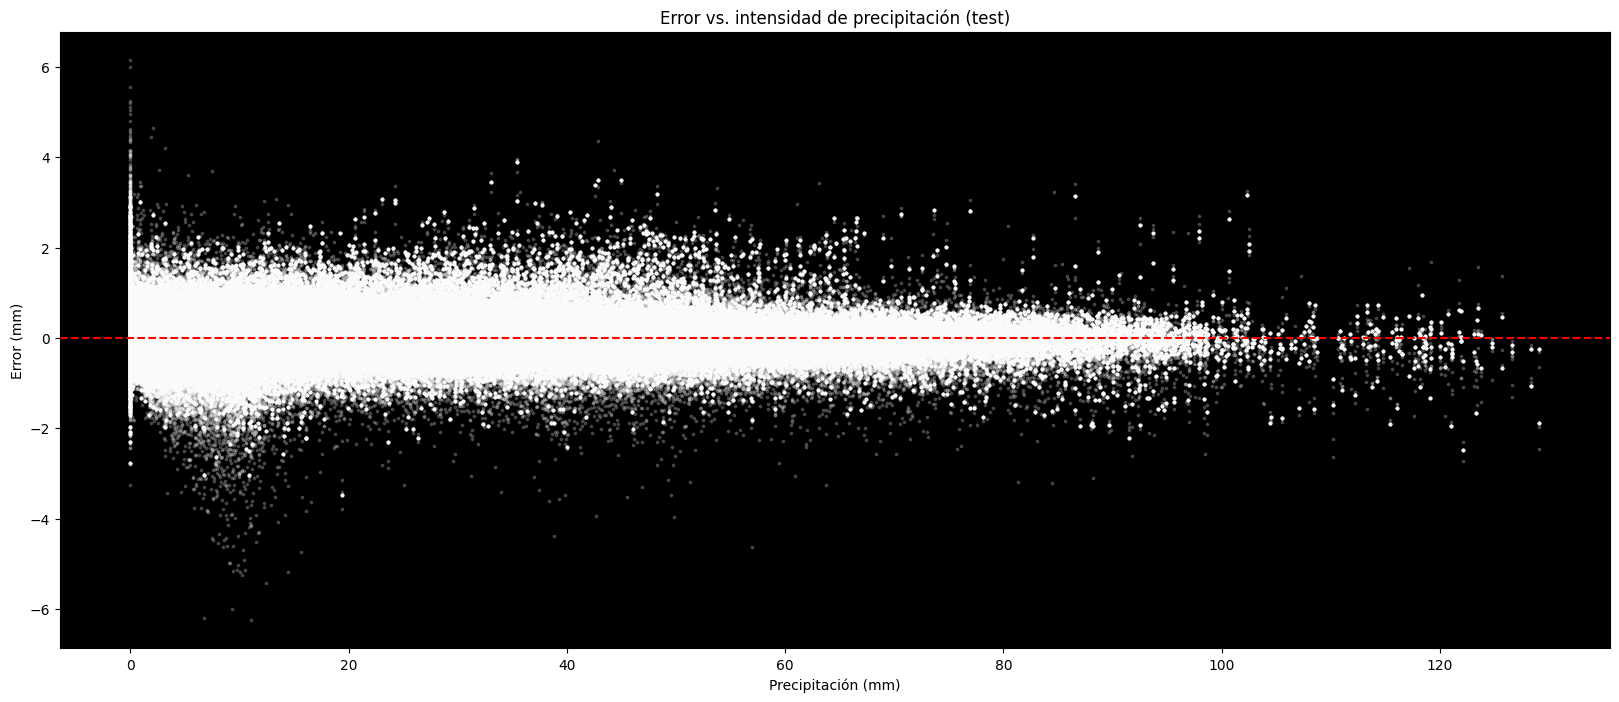

In [17]:
# Valor medio vs error (por frame)
orig_vals = (X_test[..., 0])*sd + mu
err_vals  = (Y_test*sd - X_test*sd)

plt.figure(figsize=(20,8))
fig, ax = plt.subplots(figsize=(20,8))

ax.axhline(y=0, color='r', linestyle="--")
ax.scatter(orig_vals, err_vals, s=3, alpha=0.2, color='white')
ax.set_facecolor('black')
ax.set_xlabel("Precipitación (mm)")
ax.set_ylabel("Error (mm)")
ax.set_title("Error vs. intensidad de precipitación (test)")
plt.show()

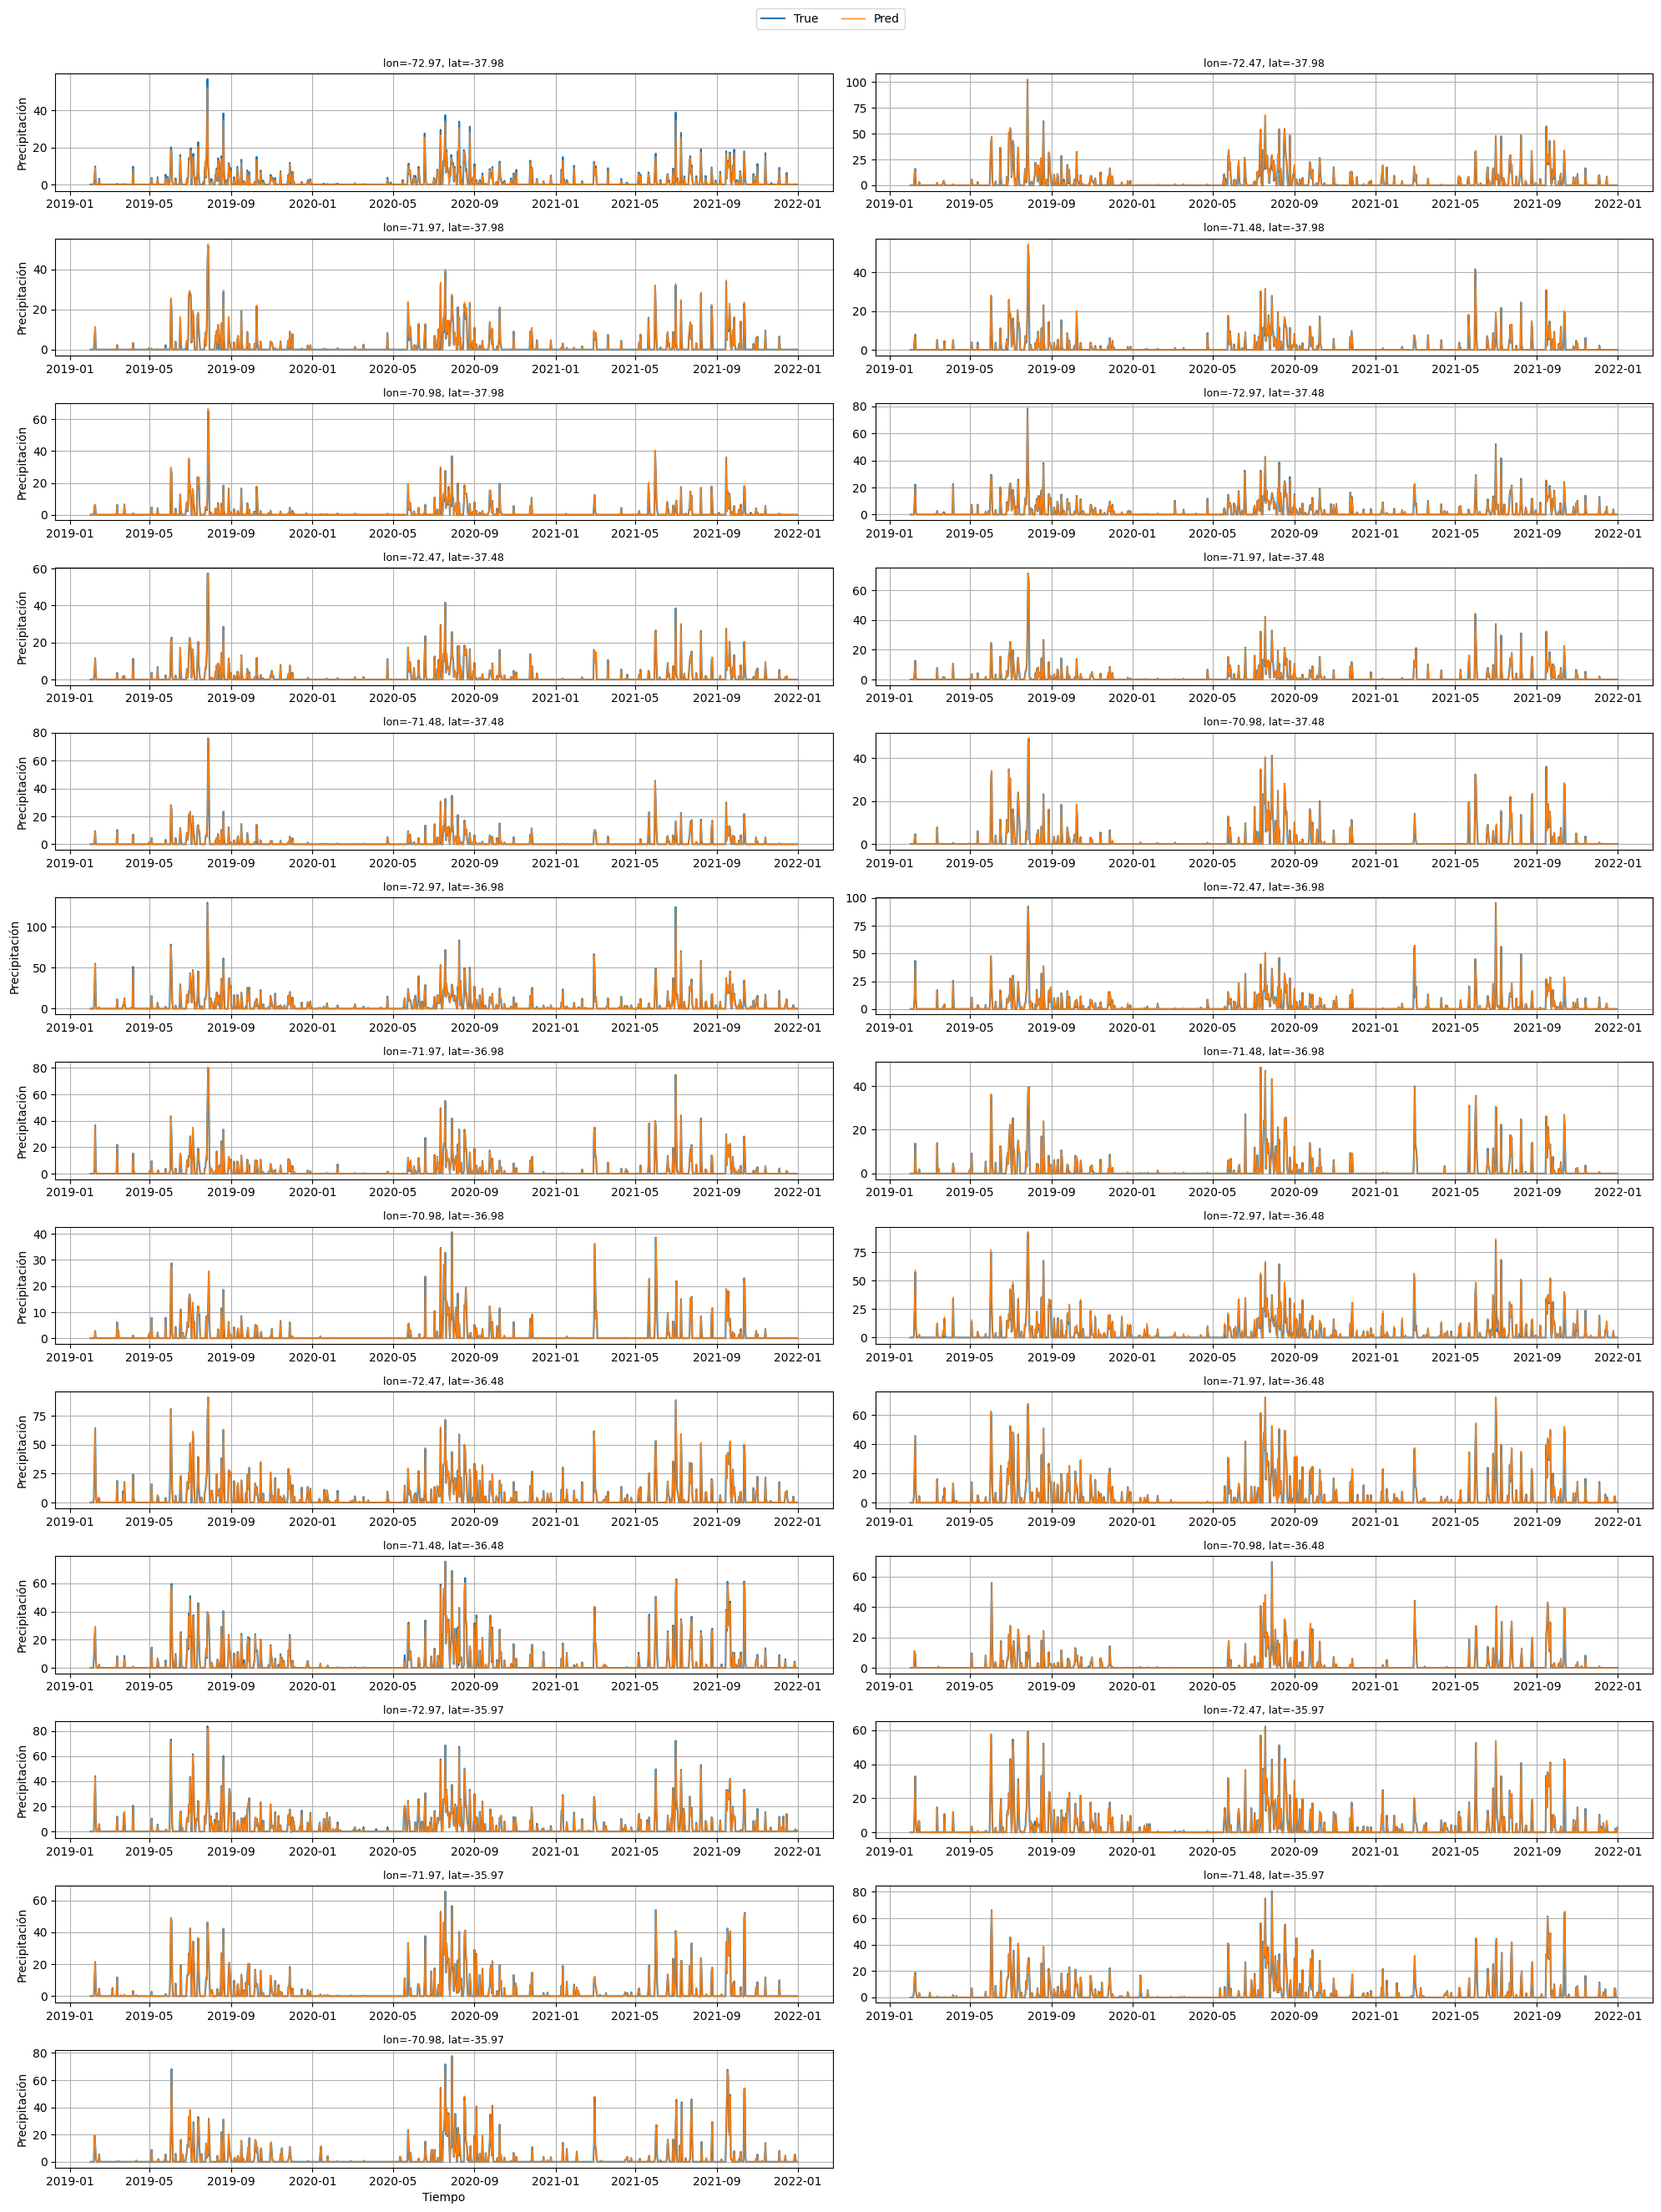

In [18]:
# --- Configuración ---
coords = [(0, 0), (10, 0), (20, 0), (30, 0), (40, 0),
          (0, 10), (10, 10), (20, 10), (30, 10), (40, 10),
          (0, 20), (10, 20), (20, 20), (30, 20), (40, 20),
          (0, 30), (10, 30), (20, 30), (30, 30), (40, 30),
          (0, 40), (10, 40), (20, 40), (30, 40), (40, 40)]
n = 13   # número de filas
m = 2   # número de columnas
assert n*m >= len(coords), "La rejilla debe tener al menos tantos subplots como coordenadas"

# --- Crear figura y ejes ---
fig, axes = plt.subplots(n, m, figsize=(20, n*2), sharex=False, sharey=False)
axes = axes.ravel()

# --- Graficar ---
for i, (lo, la) in enumerate(coords):
    ax = axes[i]
    ax.plot(ds['time'].values[-X_test.shape[0]:], (X_test*sd + mu)[:, 0, lo, la], label='True', lw=1.5)
    ax.plot(ds['time'].values[-X_test.shape[0]:], (Y_test*sd + mu)[:, 0, lo, la], label='Pred', lw=1)
    ax.set_title(f"lon={ds['longitude'].values[lo]:.2f}, lat={ds['latitude'].values[la]:.2f}", fontsize=9)
    ax.grid(True)
    if i % m == 0:
        ax.set_ylabel('Precipitación')
    if i >= (n-1)*m:
        ax.set_xlabel('Tiempo')

# --- Ocultar los subplots vacíos si sobran ---
for j in range(len(coords), n*m):
    axes[j].axis('off')

# --- Ajustes finales ---
fig.legend(['True', 'Pred'], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02))
plt.tight_layout()
plt.show()
